# True Random Number Generator using Digital Camera Noise

## What this is

In [1]:
import numpy as np
import rawpy

from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
%matplotlib inline

This is a prototype of a random number generator that uses entropy from digital photos, following [Rongzhong Li, 2015]. We do not adhere tightly to the described analysis and method. Rather, this is a quick proof of concept, but we include the main ideas like brightness clipping and bias removal. The generator is implemented as a Python class in `crandom.py`.

For simplicity, our analysis is restricted to one channel images (colorful images are supported in the implementation, but cast to grayscale).

In [2]:
from crandom import CameraNoiseTRNG

## Devices and light conditions

We use several cameras and settings: a Canon 550D DSLR and an iPhone 8 to prove the approach to be stable using different camera models. We also check the approach against raw/processed photos and various types of dominant noise. 

At normal conditions, the majority of the noise is believed to be caused by scene lighting due to the quantum nature of light. However, in dark settings, internal camera noise is expected to be dominant. We test the randomness achieved by calibrating on photos made in casually lit, medium and dark settings, and on some closed-lens shots.

## Introductory analysis

The behavior of noises is usually modeled as Additive Zero-Mean Gaussian noise with the probability density function
$$p(x) = \dfrac{1}{\sqrt{2\pi}\sigma} \exp\left( \dfrac{-(x - \mu)^2}{2\sigma^2} \right),$$
where $x$ is the observable value, $\mu$ is the mean (in our case, noise-free, 'true', brightness), and $\sigma$ is the standard deviation of the distribution. 

We assume that most of the noise in digital images is observed in the last few bits with the last bit being the most sensitive to it and thus more adherent to Gaussian process. Below there are several plots of the distribution of $n$ last bits of pixels of a sample set of similar images.

In [3]:
from utils import load_photos_from_folder, numpy_arrays_from_paths, pixel_statistics

In [4]:
def plot_image_set_bit_stats(folder, bins=40, title=''):
    sample_images = load_photos_from_folder(folder)

    plt.figure(figsize=(13, 4))
    plt.subplot(121)
    plt.imshow(sample_images[0], cmap='gray')


    plt.subplot(122)

    np.random.seed(42)

    for last_bits in range(1, 5):
        mb, sb, mlb = pixel_statistics(sample_images, last_bits)
        np.random.seed(42)
        choice = np.random.choice(np.arange(len(mb)), 10000, replace=False)
        mlb = mlb[choice]
        plt.title(title)
        plt.hist(mlb / (2 ** last_bits - 1) - 0.5,
                 label=f'{last_bits} bit{"s" if last_bits > 1 else ""}',
                 alpha=0.65, bins=bins)

    plt.legend()
    plt.show()

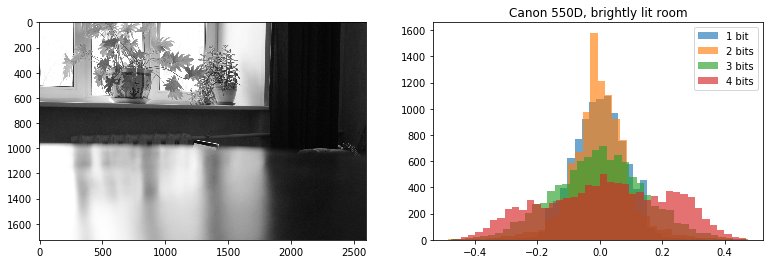

In [5]:
plot_image_set_bit_stats('photos/dslr_static/', 
                         title='Canon 550D, brightly lit room')

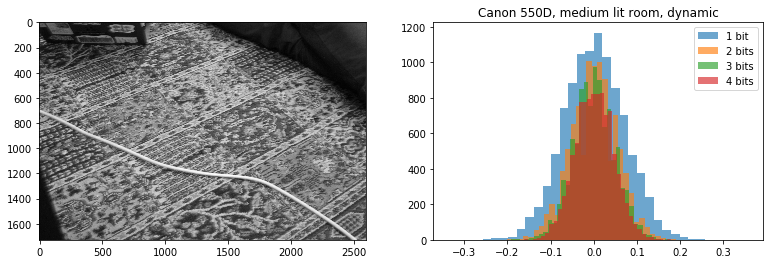

In [6]:
plot_image_set_bit_stats('photos/dslr_casual/', bins=35, 
                         title='Canon 550D, medium lit room, dynamic')

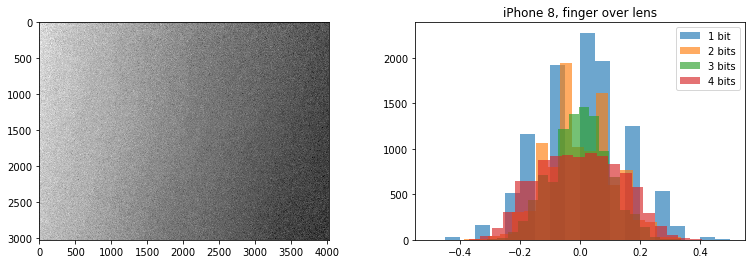

In [7]:
plot_image_set_bit_stats('photos/iphone8_closedlens/', bins=20, 
                         title='iPhone 8, finger over lens')

As can be seen, the more bits we take, the less regular and more image-dependent they are as a pixel distribution. Therefore, the most straightforward way to extract noise is to process just the least significant bit.

## Implementation details

### Bias removal

Since we'd like to have as much entropy as possible, we'd like to remove bias coming from different sources, such as camera internal properties as well as scene setting. 

The first source of bias is over- and underexposed pixels. In overly dark regions, pixels tend not to generate noise, because they do not get activated. In overly bright regions, brightness is clipped to 255, which always has 1 as the last bit.

We also assume that unbiased pixels' mean of last bit deviates by no more than 0.05 from 0.5.

In [11]:
def pixel_statistics_unclipped(photos, nbits=1):
    mean = np.round(np.mean(photos, axis=0))
    std = np.std(photos, axis=0)
    last_bit_mean = np.mean(photos & (2 ** nbits - 1), axis=0)
    mean = mean.reshape(-1)
    std = std.reshape(-1)
    last_bit_mean = last_bit_mean.reshape(-1)
    return mean, std, last_bit_mean

def plot_biasedness(folder, points=5000, random_seed=42, fmt='jpg', legend=True):
    photos = load_photos_from_folder(folder, fmt)
    mean, std, last_bit_mean = pixel_statistics_unclipped(photos)
    np.random.seed(random_seed)
    choice = np.random.choice(np.arange(len(mean)), points, replace=False)
    plt.title('')
    plt.xlabel('Mean brightness')
    bad_indices = np.abs(last_bit_mean[choice] - 0.5) >= 0.4
    plt.scatter(mean[choice], std[choice], c=last_bit_mean[choice], alpha=0.6)
    if sum(bad_indices) > 0:
        plt.scatter(mean[choice][bad_indices], std[choice][bad_indices], 
                    c=last_bit_mean[choice][bad_indices], alpha=0.8)
    if legend:
        plt.colorbar()

We perform bias exploration by looking at mean values of the last bit of pixels with different cameras and settings, against mean brightness and standard deviation of brightness.

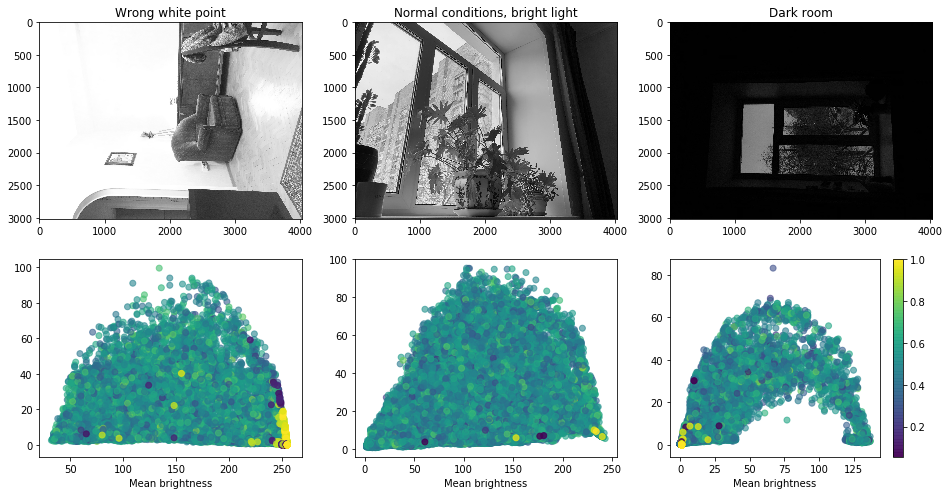

In [6]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Wrong white point')
plt.imshow(Image.open('photos/iphone8_wrong_whitepoint/IMG_0578.JPG').convert('L'))
plt.subplot(232)
plt.title('Normal conditions, bright light')
plt.imshow(Image.open('photos/iphone8/IMG_0553.JPG').convert('L'))
plt.subplot(233)
plt.title('Dark room')
plt.imshow(Image.open('photos/iphone8_dark/IMG_0598.JPG').convert('L'))
plt.subplot(234)
plot_biasedness('photos/iphone8_wrong_whitepoint/', 50000, 42, legend=False)
plt.subplot(235)
plot_biasedness('photos/iphone8/', 50000, 42, legend=False)
plt.subplot(236)
plot_biasedness('photos/iphone8_dark/', 50000, 42, legend=True)
plt.show()

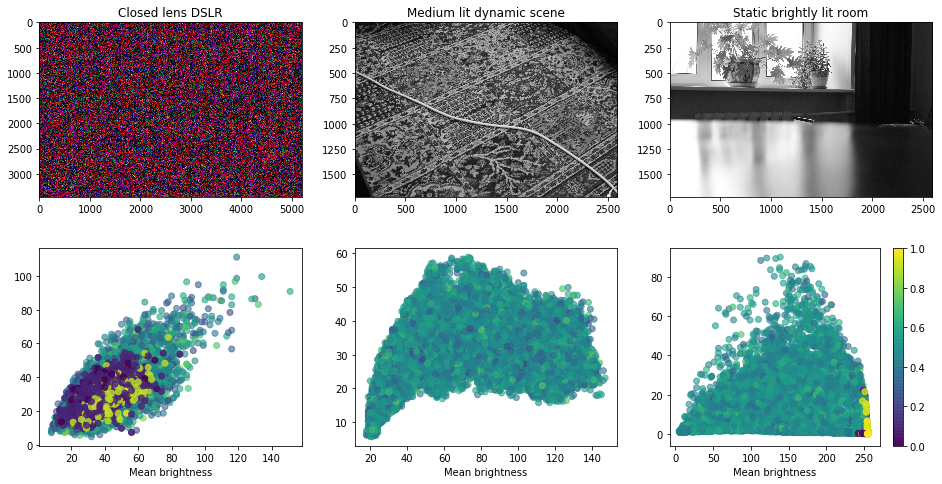

In [13]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Closed lens DSLR')
plt.imshow(rawpy.imread('photos/dslr_closedlens/1.CR2').postprocess())
plt.subplot(232)
plt.title('Medium lit dynamic scene')
plt.imshow(Image.open('photos/dslr_casual/1.JPG').convert('L'))
plt.subplot(233)
plt.title('Static brightly lit room')
plt.imshow(Image.open('photos/dslr_static/_MG_5862.JPG').convert('L'))
plt.subplot(234)
plot_biasedness('photos/dslr_closedlens/', 50000, 42, legend=False, fmt='cr2')
plt.subplot(235)
plot_biasedness('photos/dslr_casual/', 50000, 42, legend=False)
plt.subplot(236)
plot_biasedness('photos/dslr_static/', 50000, 42, legend=True)
plt.show()

### Python class API

The implemented class `CameraNoiseTRNG` contains methods `feed_entropy` to gather entropy from new photos, `random_number` with an option to choose the number of bits, and `random_bits` to gather a sequence if bits. There is an example below.

In [15]:
G = CameraNoiseTRNG('photos/dslr_static/')
other_photos = load_photos_from_folder('photos/dslr_casual/')[:2]
G.feed_entropy(other_photos)

print(G.random_bits(64), '\n')
print(' '.join([str(G.random_number(8)) for _ in range(20)]))

bitarray('0000000111110100010001001001101000100110001000001100011001100000') 

36 51 34 222 253 109 225 94 60 128 52 10 99 43 158 120 198 85 71 193


## Performance estimation

Being a prototype, our tool does not allow very fast generation, but it happens due to Python restrictions and not because of the approach. Casts and indirect bitwise operations (and naïve decisions in some places) consume most of the time, but in principle, the algorithm's bandwidth depends only on camera bandwidth and scene dynamics.

## Test results

We tested our framework on a [Python implementation](https://github.com/dj-on-github/sp800_22_tests) of the NIST SP800-22 Rev. 1a, A Statistical Suite for Random and Pseudorandom Number Generators. All calibrations pass at least 13/15 NIST tests, with two scoring PASS in full 15. Detailed logs are listed in `sequences/*.log`.

In [6]:
def generate_sequence(photos, out_file, fmt='jpg'):
    photos = load_photos_from_folder(photos, fmt=fmt)
    generator = CameraNoiseTRNG(photos)
    generator.feed_entropy(photos[-1:])
    sequence = generator.random_bits(generator.capacity())
    sequence.tofile(open(out_file, 'wb'))

In [13]:
generate_sequence('photos/iphone8/', 'sequences/i1.bin')
generate_sequence('photos/iphone8_wrong_whitepoint/', 'sequences/i2.bin')
generate_sequence('photos/iphone8_dark/', 'sequences/i3.bin')
generate_sequence('photos/dslr_static/', 'sequences/i4.bin')
generate_sequence('photos/dslr_casual/', 'sequences/i5.bin')
generate_sequence('photos/dslr_closedlens/', 'sequences/i6.bin', fmt='cr2')

It is worth mentioning that complete scores belong to the samples from a DSLR camera in medium and brightly lit settings. It is probably caused by interference of noise reduction system in iPhone's camera.

## References

- Li, R. (2015, April). A true random number generator algorithm from digital camera image noise for varying lighting conditions. In SoutheastCon 2015 (pp. 1-8). IEEE. [(pdf)](https://borntoleave.github.io/resource/RzL_TRNG_final.pdf)


- [SP800-22 Rev 1a PRNG Test Suite](https://github.com/dj-on-github/sp800_22_tests)


- [Source code on Github](https://github.com/apnkv/btrng)